In [1]:
import pandas as pd
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql.functions import col
from pyspark.sql import functions as F

from igraph import Graph
from pyspark.sql.window import Window
from pyspark.sql.functions import col

from functools import reduce
from pyspark.sql.functions import collect_set, min as min_, expr,array_min,max
from pyspark.sql.functions import lit

from pyspark.sql.types import StringType, IntegerType, LongType, FloatType, ArrayType,StructType,StructField, BooleanType

import pandas as pd
import glob

import time

import matplotlib.pyplot as plt

from pyspark.sql.types import BooleanType


In [2]:
import os
os.environ["SPARK_HOME"] =  "/root/anaconda3/lib/python3.9/site-packages/pyspark" 
os.environ["JAVA_HOME"] ="/usr"

# Lancer spark

In [3]:
findspark.init() 

def demarrer_spark(NB_CORES):
  local = f"local[{NB_CORES}]"
  # le parametre spark.local.dir indique le repertoire contenant les données temporaires ecrites sur disque lorsque le shufle ne tient pas en memoire
  appName = "PLDAC"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "320G").\
  set("spark.driver.memory","320G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.driver.maxResultSize", "20G").\
  set("spark.local.dir", "/data/bd/spark/tmp").\
  set("spark.sql.execution.arrow.pyspark.enabled", "true")
    

# # to allow sharing in memory arow format between pandas and spark : speeds up the creation of a spark df from a pandas df
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  # spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")
    
  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (NB_CORES coeurs)
  shuffle_partitions = 3 * NB_CORES
  print("shuffle", shuffle_partitions)
  spark.conf.set("spark.sql.shuffle.partitions", str(shuffle_partitions))    

  print("session démarrée, son id est ", sc.applicationId)
  return spark


# Comparaison du temps de lecture des fichier avec plusieurs degree de parallélisme

In [4]:
import time
def read_files(partition_folder,nb_partition ):
   
    def read_file(partition_file) :
        #print(partition_file)
        try:
            df = pd.read_parquet(partition_file)
            return True
        except Exception as e:
            return False

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    read_file_udf = F.udf(read_file,  BooleanType())
    read_files_df = df.withColumn(
        "read_bool",
        read_file_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            )
        )
    )
    
    return read_files_df

## Avec 2 coeurs 


In [5]:
spark = demarrer_spark(60)
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

24/04/05 14:16:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/05 14:16:54 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/05 14:16:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/05 14:16:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/05 14:16:54 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


shuffle 180
session démarrée, son id est  local-1712319415104


In [12]:
read_files_df = read_files(partition_folder , 60)

In [13]:
import time 
file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/read_files_df"
start_time = time.time()
read_files_df.write.mode("overwrite").parquet(file_path)
print(time.time() - start_time)

5.181887865066528


In [ ]:
read_files_df.collect()

/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_18.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_9.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_16.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_10.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_12.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_17.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_4.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_7.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_11.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_19.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_6.parquet
/da

d'aprés htop y a pas de parallélisme

In [ ]:
spark.stop()

## Avec 4 coeurs 

In [100]:
spark = demarrer_spark(4)
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

shuffle 12
session démarrée, son id est  local-1712316103948


In [101]:
read_files_df = read_files(partition_folder , 4)

In [102]:
read_files_df.collect()

/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_9.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_22.parquet

/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_41.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_18.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_12.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_39.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_16.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_10.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_4.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_17.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_29.parquet
/

[Row(file='22', read_bool=True),
 Row(file='39', read_bool=True),
 Row(file='46', read_bool=True),
 Row(file='32', read_bool=True),
 Row(file='11', read_bool=True),
 Row(file='6', read_bool=True),
 Row(file='45', read_bool=True),
 Row(file='35', read_bool=True),
 Row(file='49', read_bool=True),
 Row(file='33', read_bool=True),
 Row(file='43', read_bool=True),
 Row(file='28', read_bool=True),
 Row(file='30', read_bool=True),
 Row(file='89', read_bool=True),
 Row(file='75', read_bool=True),
 Row(file='67', read_bool=True),
 Row(file='73', read_bool=True),
 Row(file='64', read_bool=True),
 Row(file='86', read_bool=True),
 Row(file='74', read_bool=True),
 Row(file='79', read_bool=True),
 Row(file='65', read_bool=True),
 Row(file='90', read_bool=True),
 Row(file='93', read_bool=True),
 Row(file='70', read_bool=True),
 Row(file='57', read_bool=True),
 Row(file='135', read_bool=True),
 Row(file='130', read_bool=True),
 Row(file='101', read_bool=True),
 Row(file='124', read_bool=True),
 Row(fi

d'aprés htop y a pas de parallélisme

In [103]:
spark.stop()

## Variation du degree de parallélisme

### Le graph a était partitionné en 200 partitions

In [24]:
import time
times = []

degree_parallelisme = [10 ,20,  30, 40,  50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/*"
     read_files_df = read_files(partition_folder , d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()

shuffle 30
session démarrée, son id est  local-1712160474618


shuffle 60
session démarrée, son id est  local-1712160485284


shuffle 90
session démarrée, son id est  local-1712160492560


shuffle 120
session démarrée, son id est  local-1712160499412


shuffle 150
session démarrée, son id est  local-1712160505684


shuffle 180
session démarrée, son id est  local-1712160512355


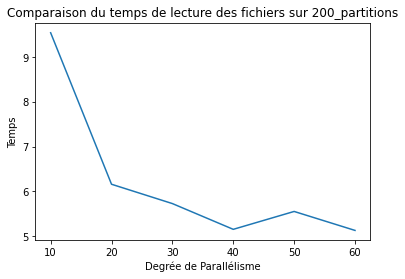

In [25]:
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

#clculer la moyenne avec le write

In [ ]:
import time
times = []

degree_parallelisme = [10 ,20,  30, 40,  50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/*"
     read_files_df = read_files(partition_folder , 200)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()

shuffle 30
session démarrée, son id est  local-1712159606828


shuffle 60
session démarrée, son id est  local-1712159618744


shuffle 90
session démarrée, son id est  local-1712159626632


shuffle 120
session démarrée, son id est  local-1712159633634


shuffle 150
session démarrée, son id est  local-1712159640026


shuffle 180
session démarrée, son id est  local-1712159646225


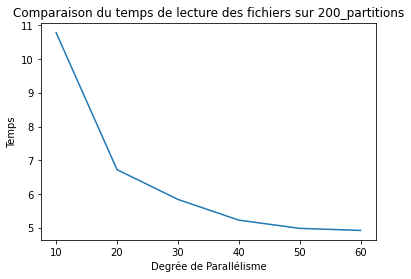

In [17]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/*"
     read_files_df = read_files(partition_folder , 3*d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

shuffle 30
session démarrée, son id est  local-1712160132939


shuffle 60
session démarrée, son id est  local-1712160143882


shuffle 90
session démarrée, son id est  local-1712160151261


shuffle 120
session démarrée, son id est  local-1712160158043


shuffle 150
session démarrée, son id est  local-1712160164620


shuffle 180
session démarrée, son id est  local-1712160170821


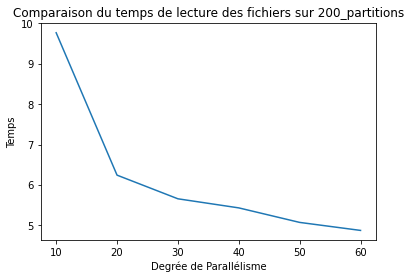

In [21]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/*"
     read_files_df = read_files(partition_folder , 2*d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 200_partitions') 

plt.show()

### Le graph a était partitionné en 60 partitions

shuffle 30
session démarrée, son id est  local-1712159831546


shuffle 60
session démarrée, son id est  local-1712159842356


shuffle 90
session démarrée, son id est  local-1712159849705


shuffle 120
session démarrée, son id est  local-1712159856414


shuffle 150
session démarrée, son id est  local-1712159862756


shuffle 180
session démarrée, son id est  local-1712159869542


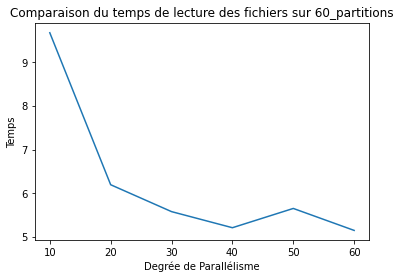

In [19]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     parquet_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/60_partitions/*"
     read_files_df = read_files(partition_folder , d)
     start_time = time.time()
     # On lance une action   
     c = read_files_df.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de lecture des fichiers sur 60_partitions') 

plt.show()

# Comparaison du temps de calcul des composantes partielles

In [4]:
def calculate_partition_components(partition_folder , nb_partition):
   
    def components(partition_file, num_file , d) :
        print(partition_file)
        df = pd.read_parquet(partition_file )
        g = Graph.TupleList(df[['query_id', 'target_id']].itertuples(index=False), directed=False)
        connected_components = g.connected_components()
        node_ids=[]
        for component in connected_components:
            node_ids.append([g.vs[node_index]['name'] for node_index in component])
        #on trie en fonction de la taille 
        composantes_triees = sorted(node_ids, key=len, reverse=True)
        # Créer une liste de lignes pour chaque composante
        rows = []
        for i, component in enumerate(composantes_triees):
            for seqid in component:
                rows.append((seqid , i)) 
                
        result_df = pd.DataFrame(rows, columns=['seqid', 'component'])
        file_path = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_{num_file}.parquet"
        result_df.to_parquet(file_path, index=False)

        return file_path

    # Schéma du DataFrame
    schema = StructType([
        StructField("file", StringType(), False)
    ])
    
    # Données à partir desquelles créer le DataFrame
    #data = [(file,) for file in os.listdir(partition_folder)]
    data = [(i,) for i, file in enumerate(os.listdir(partition_folder))]

    # Création du DataFrame
    df = spark.createDataFrame(data, schema).repartition(nb_partition)
    # Enregistrer la fonction UDF
    schema_components = StructType([
        StructField("seqID", StringType(), nullable=False),
        StructField("component_id", IntegerType(), nullable=False)
    ])
    components_udf = F.udf(components, StringType())
    #df_with_components = df.withColumn("components", components_udf(F.concat(F.lit(partition_folder+"/"), df["file"])))
    df_with_components = df.withColumn(
        "components",
        components_udf(
            F.concat(
                F.lit(partition_folder + "/partition_"), 
                df["file"] , 
                F.lit(".parquet")
            ) , 
            df["file"],
            F.lit(nb_partition)
        )
    )
    
    return df_with_components

In [5]:
spark = demarrer_spark(2)

24/04/05 13:37:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/05 13:37:45 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/05 13:37:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/05 13:37:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/04/05 13:37:45 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


shuffle 6
session démarrée, son id est  local-1712317065862


In [6]:
partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"

In [7]:
df_with_component = calculate_partition_components(partition_folder , 2)

In [8]:
df_with_component.collect()

/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_0.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_1.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_3.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_2.parquet


[Row(file='1', components='/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_1.parquet'),
 Row(file='3', components='/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_3.parquet'),
 Row(file='0', components='/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_0.parquet'),
 Row(file='2', components='/data/bd/dataset/proteine/80_80/G99/graph_partitionned_components/200_partitions_components/partition_2.parquet')]

j'ai pas remarqué de parrallélisme ici

In [86]:
spark.stop()

In [88]:
import time
times = []

degree_parallelisme = [10,20, 30, 40, 50, 60]

for d in degree_parallelisme :
     spark = demarrer_spark(d)
     partition_folder = f"/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions"
     df_with_component = calculate_partition_components(partition_folder , d)
     start_time = time.time()
     # On lance une action   
     c = df_with_component.collect()
     end_time = time.time()
     times.append(end_time-start_time)
    
     spark.stop()


shuffle 30
session démarrée, son id est  local-1712291445342


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_18.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_19.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_11.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_12.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_16.parquet



/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_9.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_17.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_4.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_7.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_10.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_3.parquet
/da

shuffle 60
session démarrée, son id est  local-1712291567614


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_4.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_36.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_6.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_9.parquet

/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_28.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_14.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_19.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_13.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_35.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_2.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_3.parquet
/dat

shuffle 90
session démarrée, son id est  local-1712291641369


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_91.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_26.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_22.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_11.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_7.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_82.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_30.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_12.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_10.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_28.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_6.parquet
/

shuffle 120
session démarrée, son id est  local-1712291705599


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_39.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_6.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_7.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_14.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_38.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_22.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_26.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_36.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_49.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_31.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_25.parquet
/

shuffle 150
session démarrée, son id est  local-1712291761693


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_196.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_53.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_65.parquet


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_54.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_7.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_35.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_37.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_193.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_77.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_17.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_64.parque

shuffle 180
session démarrée, son id est  local-1712291822000


/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_74.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_28.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_58.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_6.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_57.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_54.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_1.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_35.parquet
/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_102.parquet/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_7.parquet

/data/bd/dataset/proteine/80_80/G99/graph_partitionned/200_partitions/partition_24.parquet
/

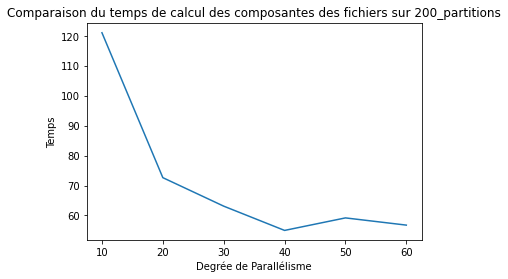

In [90]:
plt.plot(degree_parallelisme, times)

plt.xlabel('Degrée de Parallélisme')
plt.ylabel('Temps')
plt.title('Comparaison du temps de calcul des composantes des fichiers sur 200_partitions') 

plt.show()